---
title: Data Exploration
format:
    html:
        embed-resources: true
        code-fold: true
---

# Exploratory Data Analysis

In order to do machine learning with our data, we need to develop a thorough understanding of the data and the relationships between the variables. We will do Exploratory Data Analysis (EDA) to understand the data and to prepare for modeling.

## Text Data

To begin, we can explore the textual data gathered that relates to psychosis and cannabis. This text data will be essential for answering questions regarding public sentiment related to the impact of cannabis on psychosis and/or schizophrenia.

### Reddit



In [90]:
library(tidyverse, quietly = TRUE, warn.conflicts = FALSE)

wiki_data <- read_csv("../data/clean_data/wiki_cleaned_text.csv")

Rows: 397 Columns: 2


-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): link, text

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
reddit_data <- read_csv(
        "../data/clean_data/reddit_cleaned_text.csv"
    )

Rows: 30000 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): label, text

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
library(ggwordcloud)
library(tidytext)
library(wordcloud)

In [128]:
wiki_data <- wiki_data %>%
    mutate(cannabis_label = case_when(
        str_detect(text, "cannabis|marijuana|weed|THC|CBD") ~ "cannabis",
        TRUE ~ "no cannabis"
    )) %>%
    mutate(schiz_label = case_when(
        str_detect(text, "psychosis|psychotic|schizophrenia|schizophrenic|schizo|schizoaffective|schizotypal|schizoid|schiz") ~ "psychosis",
        TRUE ~ "no psychosis"
    )) %>%
    mutate(label = case_when(
        cannabis_label == "cannabis" & schiz_label == "psychosis" ~ "cannabis and psychosis",
        cannabis_label == "cannabis" & schiz_label == "no psychosis" ~ "cannabis",
        cannabis_label == "no cannabis" & schiz_label == "psychosis" ~ "psychosis",
        TRUE ~ "no cannabis and no psychosis"
    ))

In [129]:
tidy_wiki <- wiki_data %>%
    distinct() %>%
    filter(!is.na(text)) %>%
    unnest_tokens(word, text) %>%
    group_by(label, word) %>%
    summarise(n = n()) %>%
    ungroup() %>%
    group_by(word) %>%
    mutate(word_count = sum(n)) %>%
    ungroup() %>%
    arrange(-word_count)

`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.


In [130]:
tidy_wiki <- tidy_wiki %>%
  anti_join(stop_words) %>%
  filter(word != "numbr")

Joining with `by = join_by(word)`


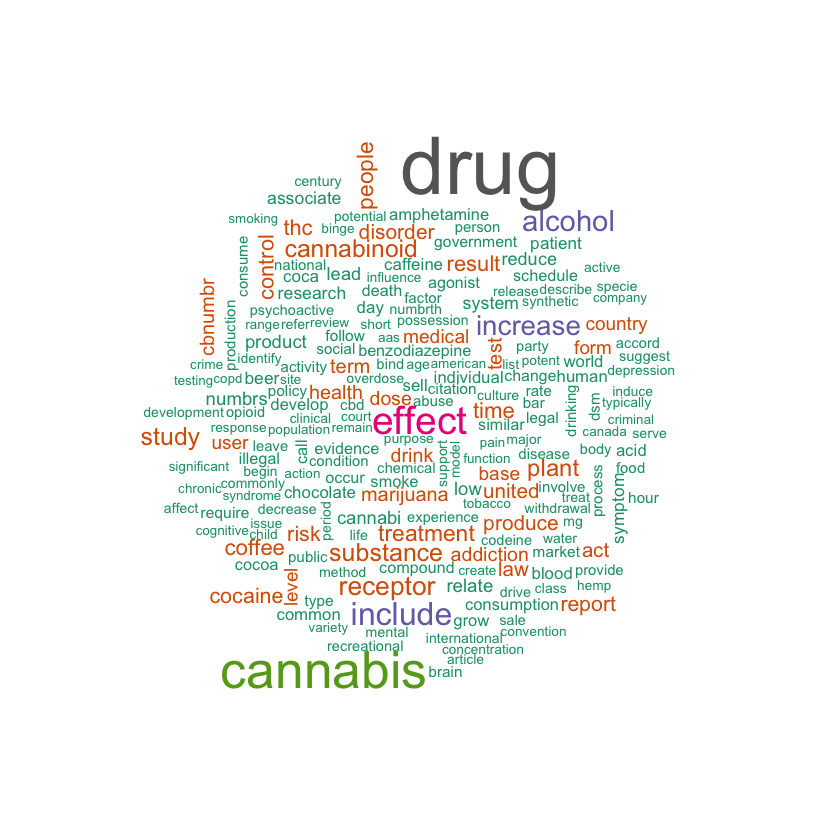

In [94]:
library(wordcloud)

tidy_wiki %>%
    select(word, word_count) %>%
    distinct() %>%
    with(wordcloud(word, word_count, max.words = 200, colors = brewer.pal(8, "Dark2")))

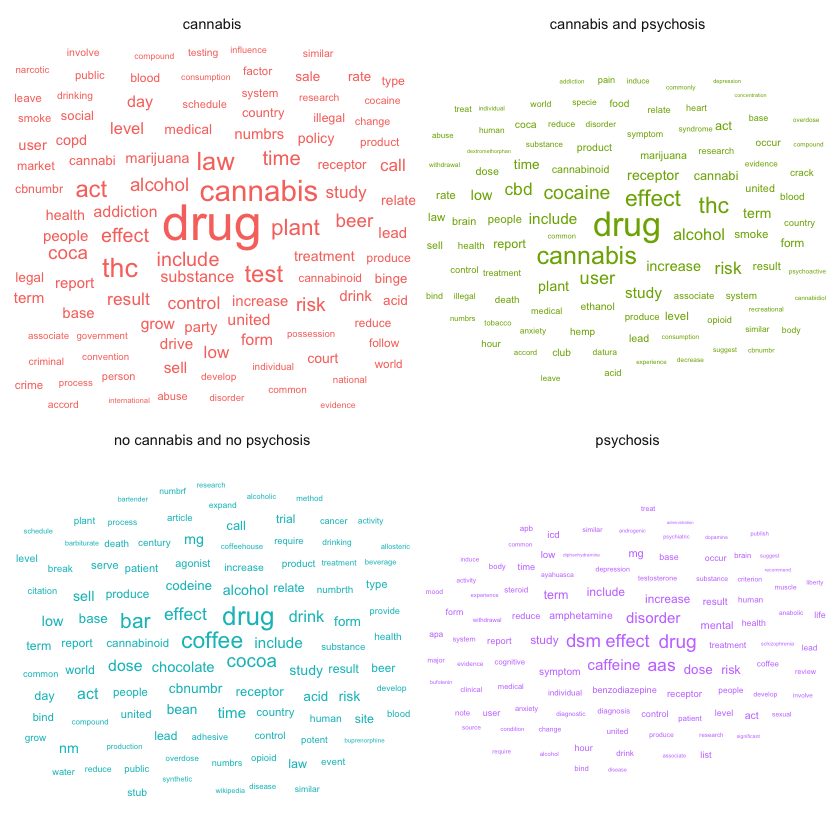

In [131]:
tidy_wiki %>%
    filter(stringi::stri_enc_isascii(word)) %>%
    group_by(label) %>%
    arrange(-n) %>%
    slice_head(n = 100) %>%
    ggplot(aes(label = word, size = n, color = label)) +
    geom_text_wordcloud_area(rm_outside = TRUE) +
    scale_size_area(max_size = 20) +
    theme_minimal() +
    facet_wrap(~label)

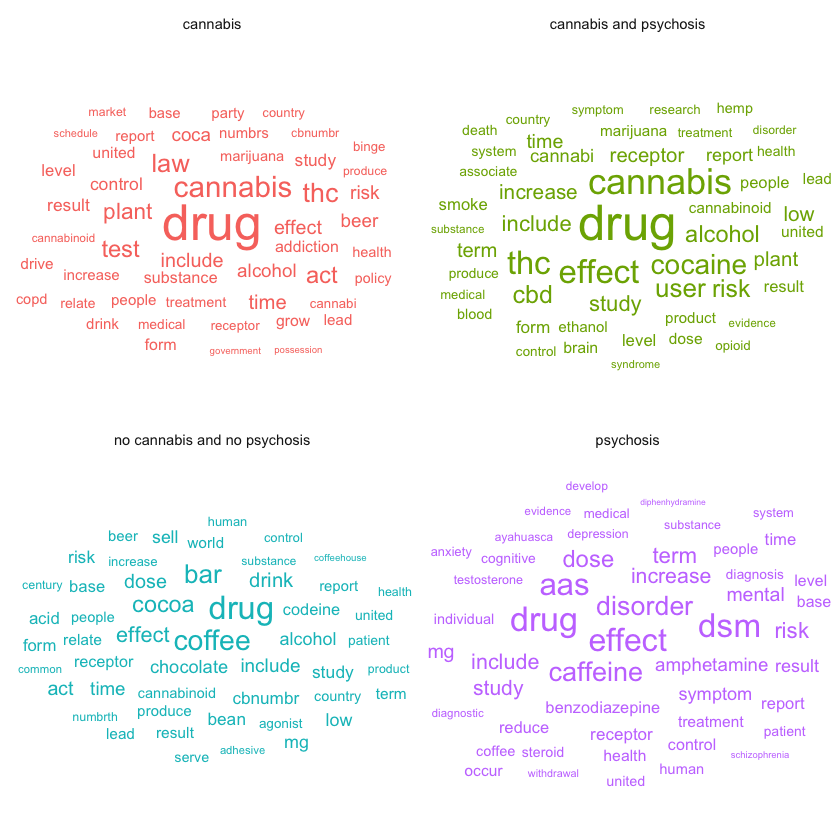

In [132]:
tidy_wiki %>%
    filter(stringi::stri_enc_isascii(word)) %>%
    group_by(label) %>%
    mutate(m = n / sum(n)) %>%
    arrange(-m) %>%
    slice_head(n = 50) %>%
    ggplot(aes(label = word, size = m, color = label)) +
    geom_text_wordcloud_area(rm_outside = TRUE) +
    scale_size_area(max_size = 20) +
    theme_minimal() +
    facet_wrap(~label)

In [133]:
tidy_wiki %>%
    mutate(nchar = nchar(word)) %>%
    group_by(label) %>%
    summarize(mean = mean(nchar))

label,mean
<chr>,<dbl>
cannabis,7.696249
cannabis and psychosis,7.767887
no cannabis and no psychosis,7.631243
psychosis,8.038816


In [134]:
wiki_data %>%
    distinct() %>%
    filter(!is.na(text)) %>%
    mutate(sentence_length = stringr::str_count(text, "\\S+")) %>%
    group_by(label) %>%
    summarize(mean = mean(sentence_length), median = median(sentence_length), n = n())

label,mean,median,n
<chr>,<dbl>,<dbl>,<int>
cannabis,783.2434,266.5,152
cannabis and psychosis,2391.0417,2006.5,24
no cannabis and no psychosis,388.6061,69.0,198
psychosis,2205.4706,1381.0,17


In [135]:
tidy_wiki %>%
    group_by(label) %>%
    summarise(n = n())

label,n
<chr>,<int>
cannabis,12902
cannabis and psychosis,7673
no cannabis and no psychosis,10812
psychosis,6183


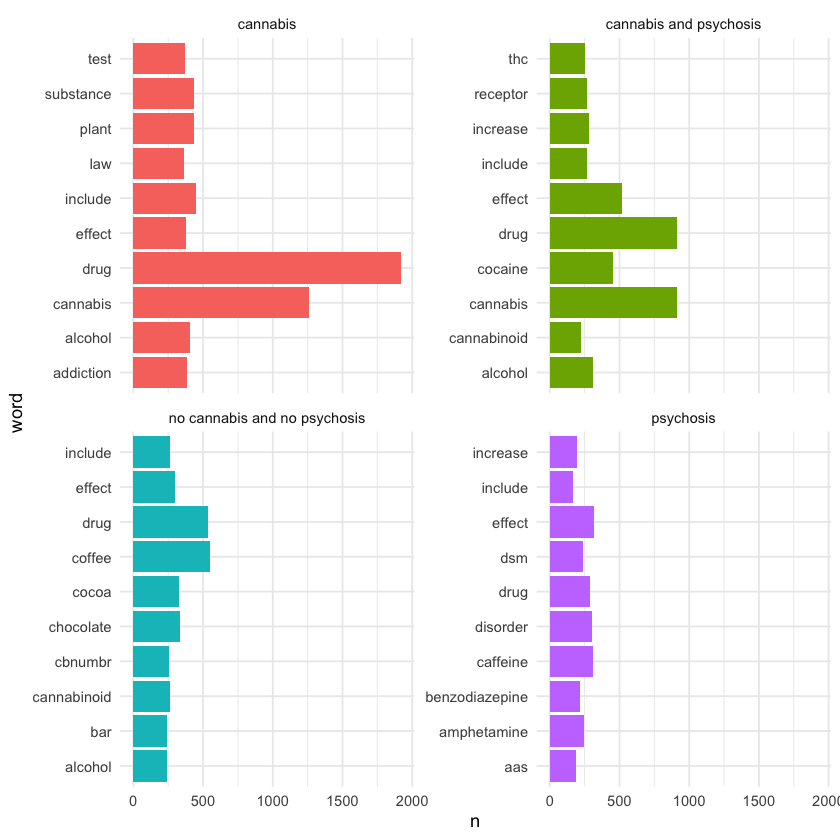

In [137]:
tidy_wiki %>%
    filter(stringi::stri_enc_isascii(word)) %>%
    group_by(label) %>%
    arrange(-n) %>%
    slice_head(n = 10) %>%
    ggplot(aes(x = n, y = word, fill = label)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    facet_wrap(~label, scales = "free_y") +
    theme(legend.position = "none")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


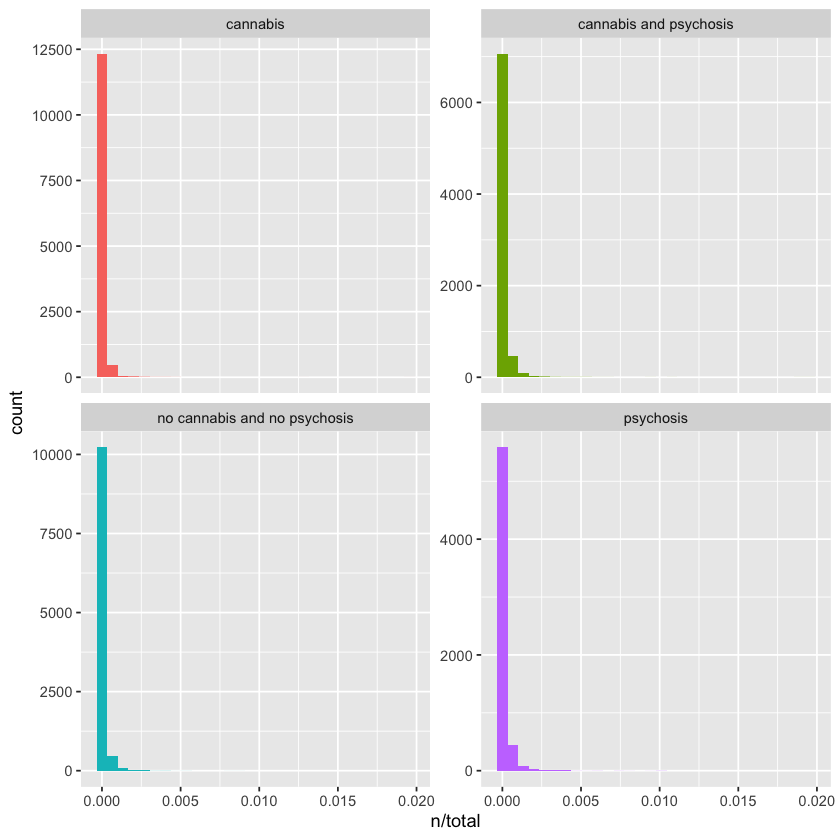

In [139]:
tidy_wiki %>%
    group_by(label) %>%
    mutate(total = sum(n)) %>%
    ggplot(aes(n/total, fill = label)) +
    geom_histogram(show.legend = FALSE) +
    facet_wrap(~label, ncol = 2, scales = "free_y")

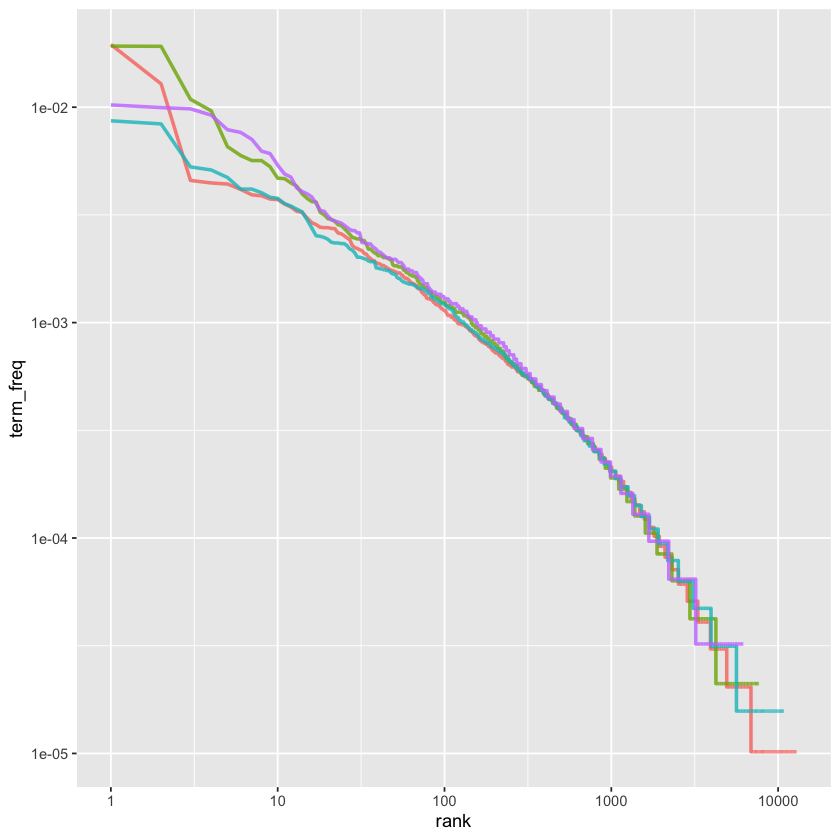

In [140]:
tidy_wiki %>%
  group_by(label) %>%
  mutate(total = sum(n)) %>%
  arrange(label, -n) %>%
  mutate(rank = row_number(), term_freq = n/total) %>%
  ungroup() %>%
  ggplot(aes(rank, term_freq, color = label)) + 
  geom_line(size = 1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

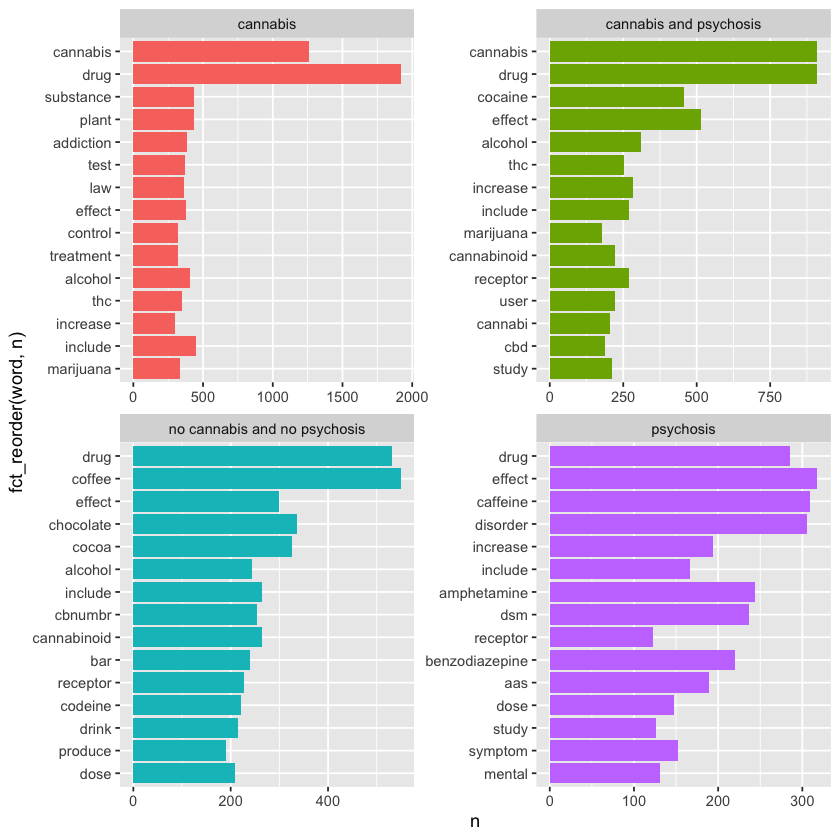

In [142]:
tidy_wiki %>%
  group_by(label) %>%
  slice_max(n, n = 15) %>%
  ungroup() %>%
  ggplot(aes(n, fct_reorder(word, n), fill = label)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~label, ncol = 2, scales = "free")

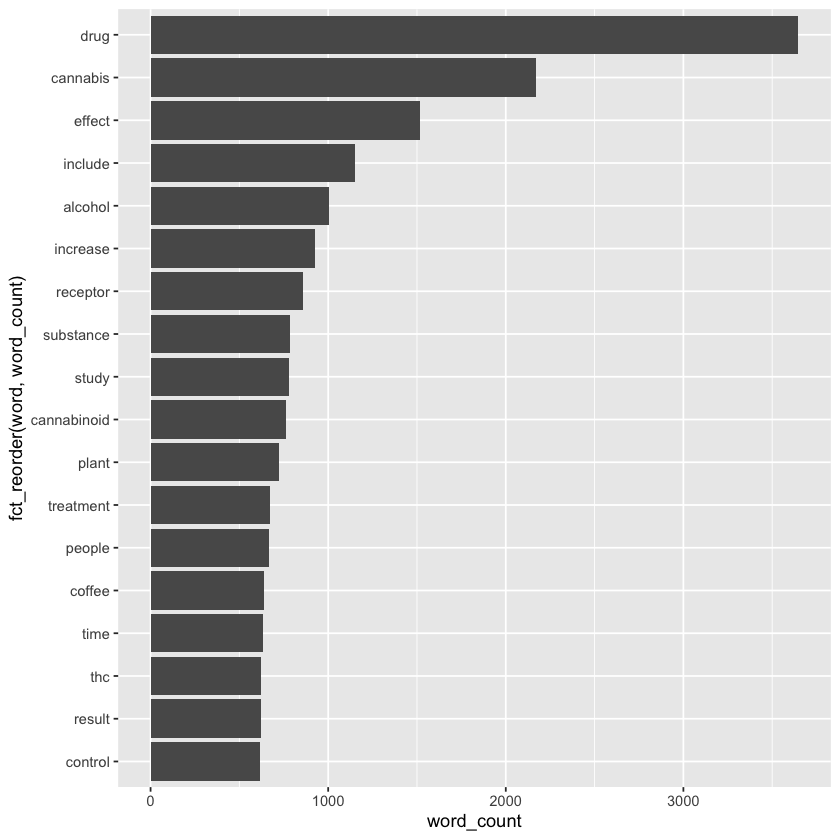

In [147]:
tidy_wiki %>%
    select(word, word_count) %>%
    distinct() %>%
    filter(word_count >= 600) %>%
    ggplot() +
    geom_bar(aes(y = fct_reorder(word, word_count), x = word_count), stat = "identity")

In [9]:
tidy_reddit <- reddit_data %>%
    distinct() %>%
    filter(!is.na(text)) %>%
    unnest_tokens(word, text) %>%
    group_by(label, word) %>%
    summarise(n = n()) %>%
    ungroup() %>%
    group_by(word) %>%
    mutate(word_count = sum(n)) %>%
    ungroup() %>%
    arrange(-word_count)

`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.


In [10]:
tidy_reddit <- tidy_reddit %>%
  anti_join(stop_words) %>%
  filter(word != "numbr")

Joining with `by = join_by(word)`


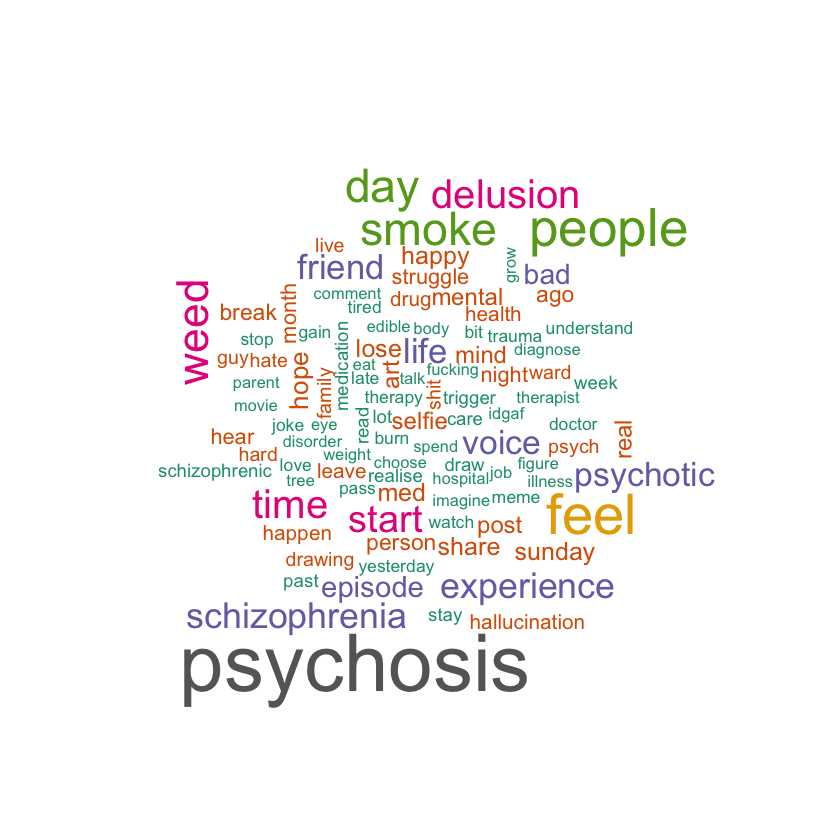

In [11]:
tidy_reddit %>%
    select(word, word_count) %>%
    distinct() %>%
    with(wordcloud(word, word_count, max.words = 100, colors = brewer.pal(8, "Dark2")))

Warning message in wordcloud_boxes(data_points = points_valid_first, boxes = boxes, :
"Some words could not fit on page. They have been removed."


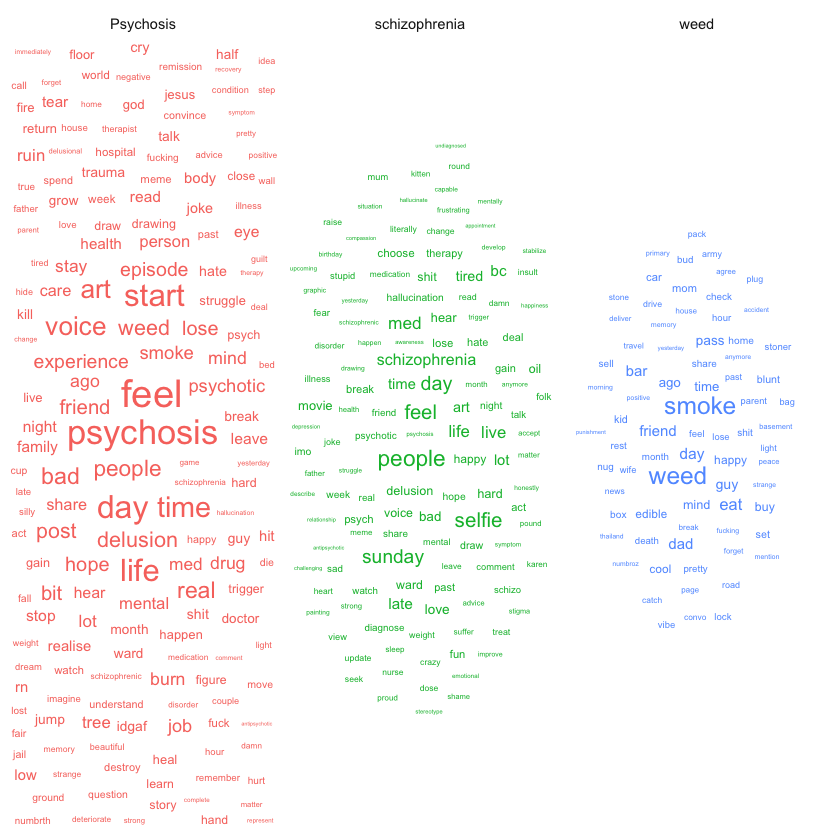

In [21]:
ggplot(
  tidy_reddit %>% filter(stringi::stri_enc_isascii(word)) %>% filter(n >= 2),
  aes(
    label = word, size = n, color = label
  )
) +
  geom_text_wordcloud_area(rm_outside = TRUE) +
  scale_size_area(max_size = 20) +
  theme_minimal() +
  facet_wrap(~label)

In [26]:
tidy_reddit %>%
    mutate(nchar = nchar(word)) %>%
    group_by(label) %>%
    summarize(mean = mean(nchar))

label,mean
<chr>,<dbl>
Psychosis,6.411458
schizophrenia,6.291242
weed,5.555046


In [30]:
reddit_data %>%
    distinct() %>%
    filter(!is.na(text)) %>%
    mutate(sentence_length = stringr::str_count(text, "\\S+")) %>%
    group_by(label) %>%
    summarize(mean = mean(sentence_length))

label,mean
<chr>,<dbl>
Psychosis,26.979381
schizophrenia,10.802083
weed,8.262626


In [32]:
tidy_reddit %>%
    group_by(label) %>%
    summarise(n = n())

label,n
<chr>,<int>
Psychosis,960
schizophrenia,491
weed,436


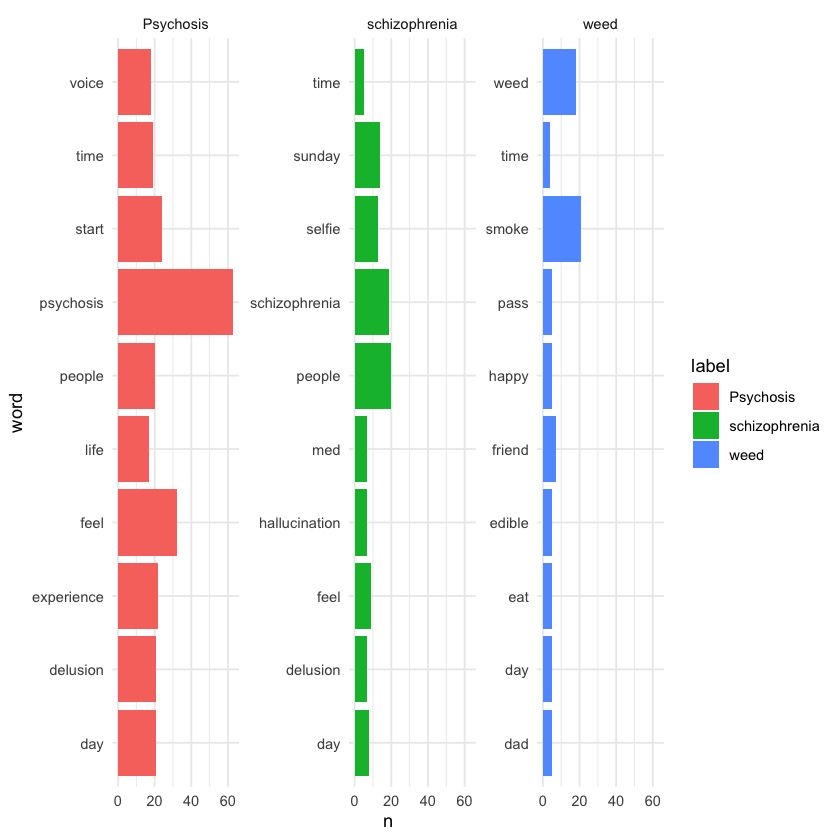

In [42]:
tidy_reddit %>%
    filter(stringi::stri_enc_isascii(word)) %>%
    group_by(label) %>%
    arrange(-n) %>%
    slice_head(n = 10) %>%
    ggplot(aes(x = n, y = word, fill = label)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    facet_wrap(~label, scales = "free_y")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


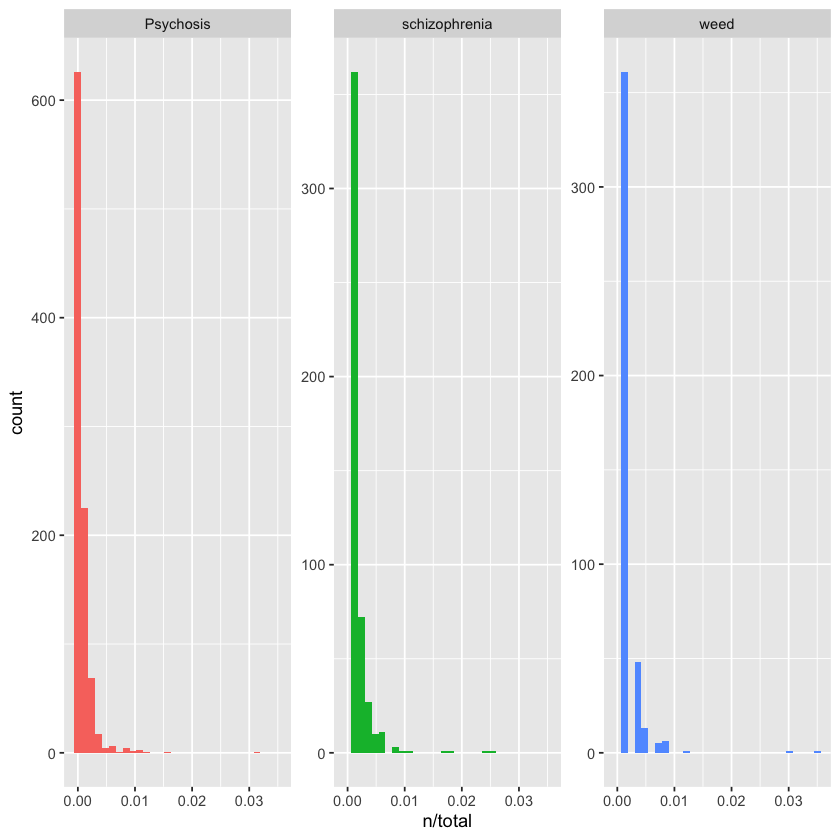

In [53]:
tidy_reddit %>%
    group_by(label) %>%
    mutate(total = sum(n)) %>%
    ggplot(aes(n/total, fill = label)) +
    geom_histogram(show.legend = FALSE) +
    facet_wrap(~label, ncol = 3, scales = "free_y")

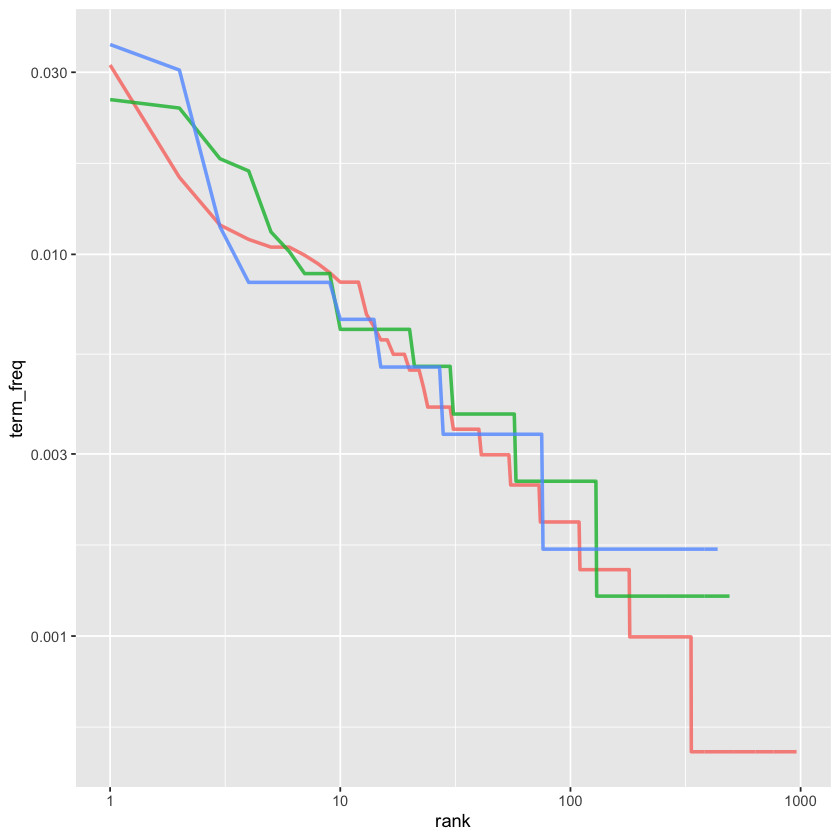

In [67]:
tidy_reddit %>%
  group_by(label) %>%
  mutate(total = sum(n)) %>%
  arrange(label, -n) %>%
  mutate(rank = row_number(), term_freq = n/total) %>%
  ungroup() %>%
  ggplot(aes(rank, term_freq, color = label)) + 
  geom_line(size = 1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

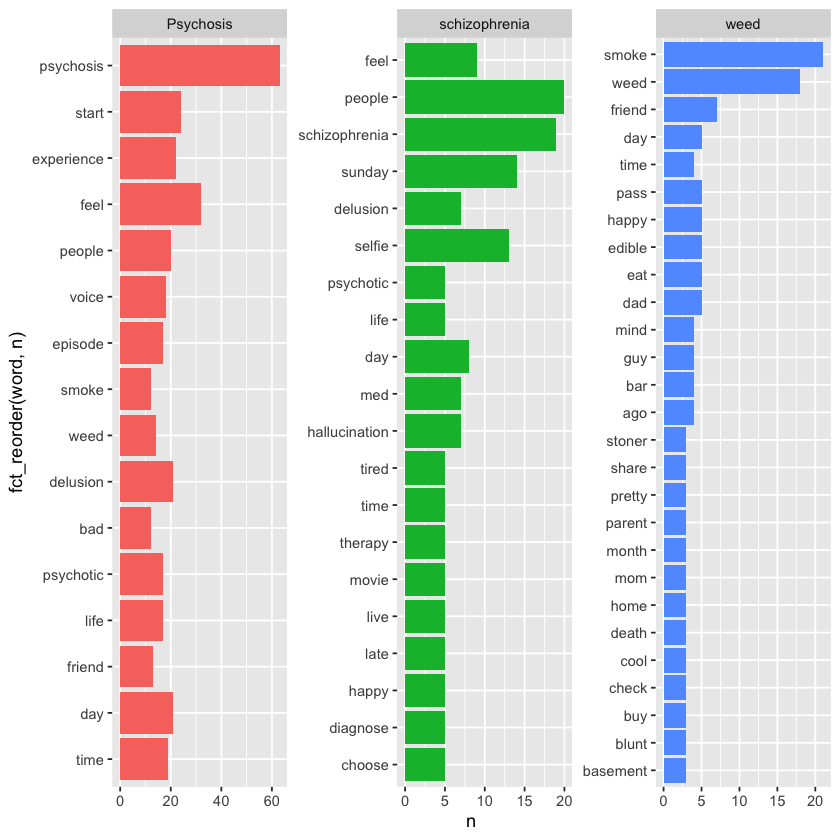

In [86]:
tidy_reddit %>%
  group_by(label) %>%
  slice_max(n, n = 15) %>%
  ungroup() %>%
  ggplot(aes(n, fct_reorder(word, n), fill = label)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~label, ncol = 3, scales = "free")

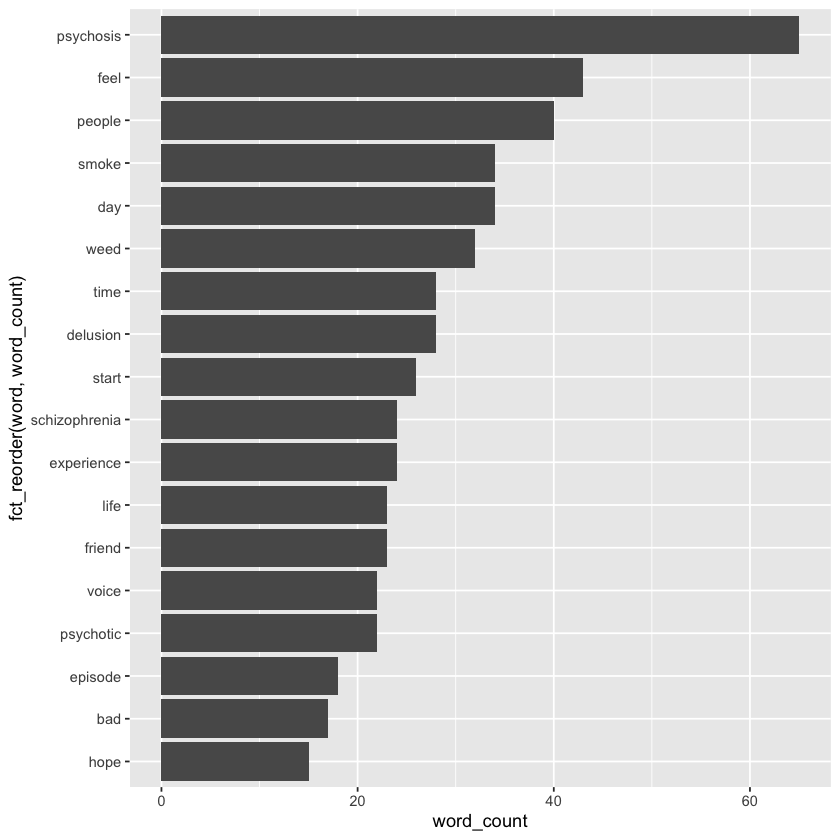

In [150]:
tidy_reddit %>%
    select(word, word_count) %>%
    distinct() %>%
    filter(word_count >= 15) %>%
    ggplot() +
    geom_bar(aes(y = fct_reorder(word, word_count), x = word_count), stat = "identity")

## Record Data

In [151]:
s1 <- read_csv("../data/clean_data/s1file_clean.csv")

Rows: 549 Columns: 24
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (24): Code, Program, sex, age, age_psychosis, famhis, hospita, dui, dup,...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [152]:
s2 <- read_csv("../data/clean_data/s2file_clean.csv")

Rows: 477 Columns: 23
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (23): code, Program, sex, age, agepsychosis, fampsic, hospita, dui, dup,...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [154]:
setdiff(names(s1), names(s2))

[1] "Code"              "age_psychosis"     "famhis"           
[4] "levelsocioeco"     "dasgl0"            "Diagnosisobinnary"
[7] "insight"

In [155]:
setdiff(names(s2), names(s1))

[1] "code"             "agepsychosis"     "fampsic"          "levelecon"       
[5] "cds0"             "Diagnosisbinario"

In [328]:
full_data <- s1 %>% 
    rename(
        code = Code,
        diagnosis = Diagnosisobinnary,
        family_history = famhis
    ) %>%
    left_join(
        s2 %>%
            rename(
                diagnosis = Diagnosisbinario,
                age_psychosis = agepsychosis,
                family_history = fampsic,
                levelsocioeco = levelecon
            )
    )

Joining with `by = join_by(code, Program, sex, age, age_psychosis,
family_history, hospita, dui, dup, levelsocioeco, urbanarea, livingwithparents,
unmarried, unemployed, years_edu, CannabisBinary, SAPS0, SANS0, Psychoticdim0,
Disorganizeddim0, Negativedimen0, diagnosis)`


In [204]:
full_data %>% head()

code,Program,sex,age,age_psychosis,family_history,hospita,dui,dup,levelsocioeco,...,CannabisBinary,SAPS0,SANS0,Psychoticdim0,Disorganizeddim0,Negativedimen0,dasgl0,diagnosis,insight,cds0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,22.24658,22.16324,2,2,2.0,1.0,1,...,1,6,6,4,2,5,2,1,1,NA
2,1,0,32.67945,32.63779,1,2,0.5,0.5,2,...,1,9,5,8,1,4,0,1,1,NA
3,1,0,30.23562,30.15228,2,1,36.0,1.0,NA,...,1,11,2,4,7,0,NA,1,NA,NA
4,1,0,24.80274,24.46941,2,2,18.0,4.0,2,...,1,14,10,8,6,7,0,0,2,NA
5,1,0,22.38082,21.38082,2,1,28.0,12.0,1,...,1,11,22,4,7,18,2,0,2,NA
6,1,0,17.07671,16.99338,2,1,1.0,1.0,2,...,1,10,5,4,6,5,0,1,2,NA


In [329]:
full_data <- full_data %>%
    mutate(
        across(
            c(code, Program, sex, family_history, diagnosis, 
            hospita, levelsocioeco, urbanarea, livingwithparents,
            unmarried, unemployed, CannabisBinary
            ),
            ~ as.factor(.x)
        )
    )

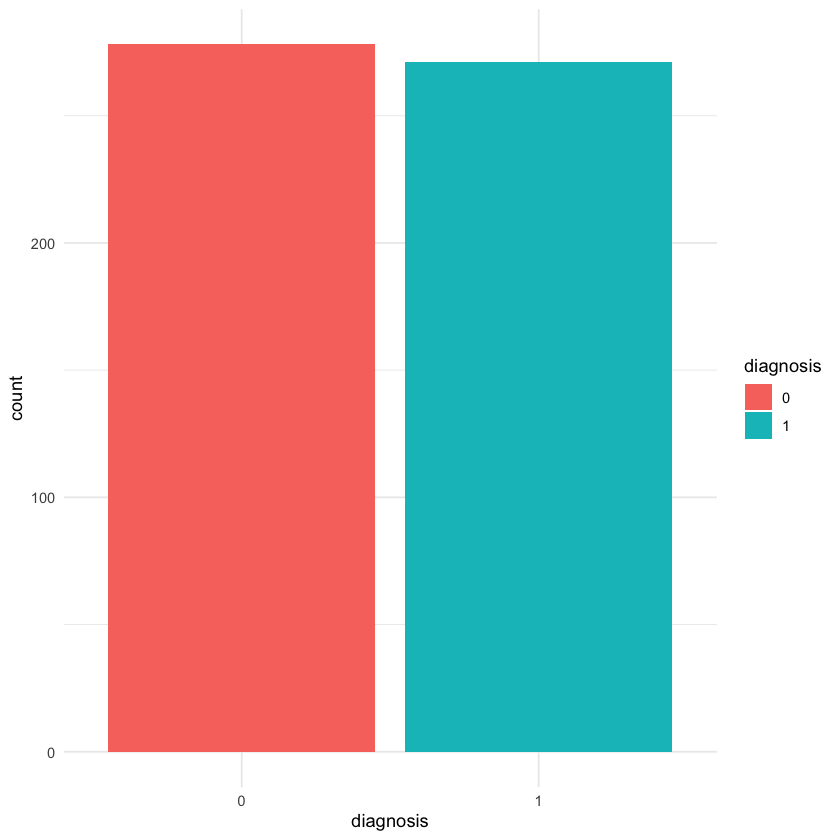

In [330]:
full_data %>%
    ggplot() +
    geom_bar(aes(x = diagnosis, fill = diagnosis)) +
    theme_minimal()

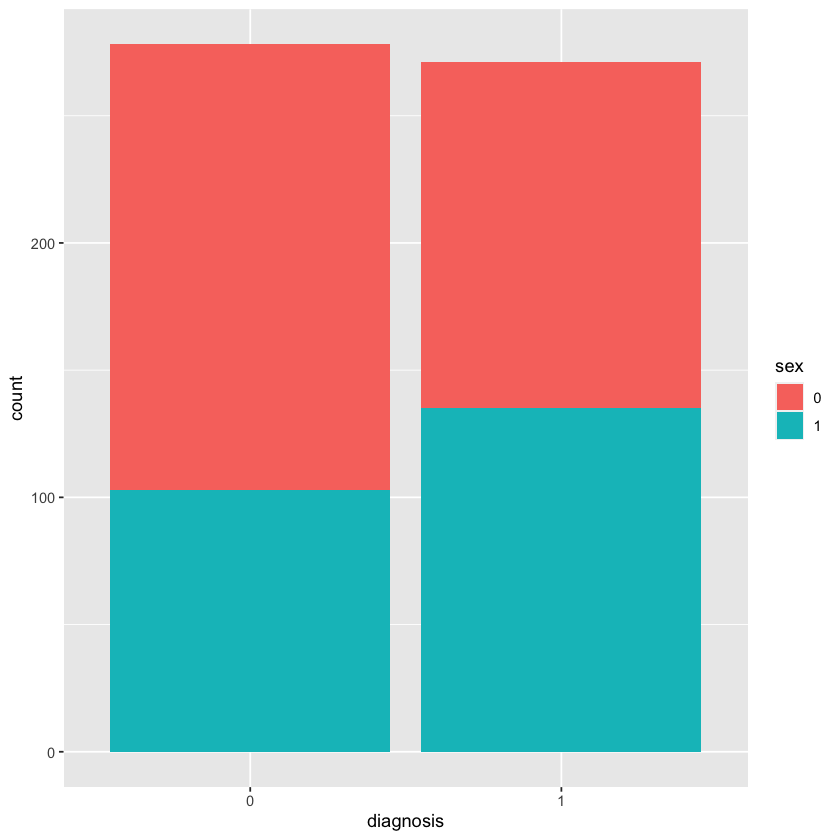

In [331]:
full_data %>%
    ggplot() +
    geom_bar(aes(x = diagnosis, fill = sex))

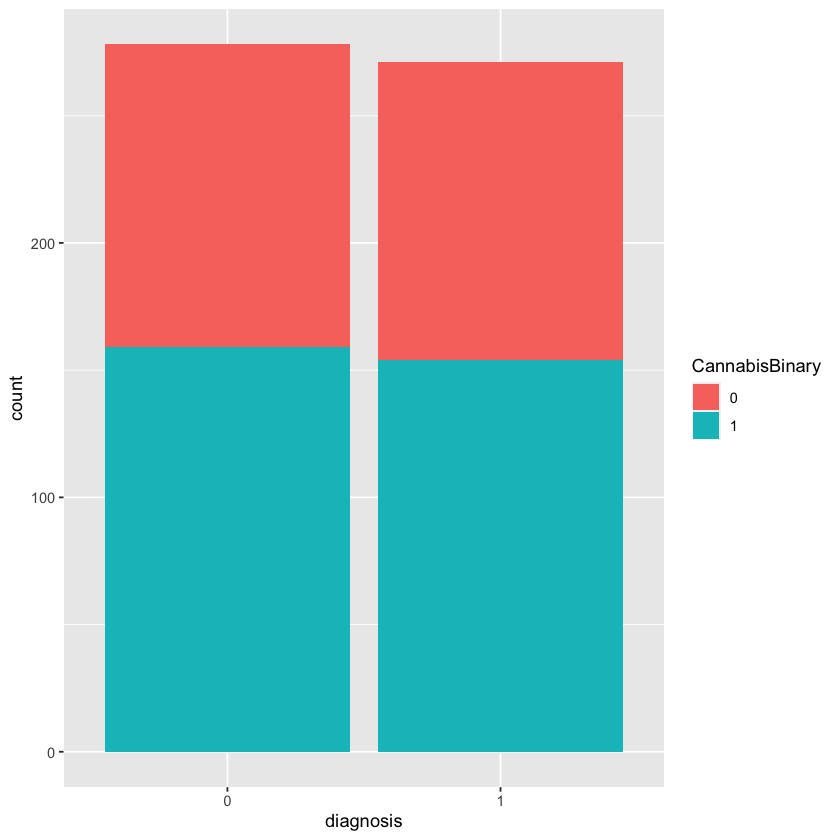

In [332]:
full_data %>%
    ggplot() +
    geom_bar(aes(x = diagnosis, fill = CannabisBinary))

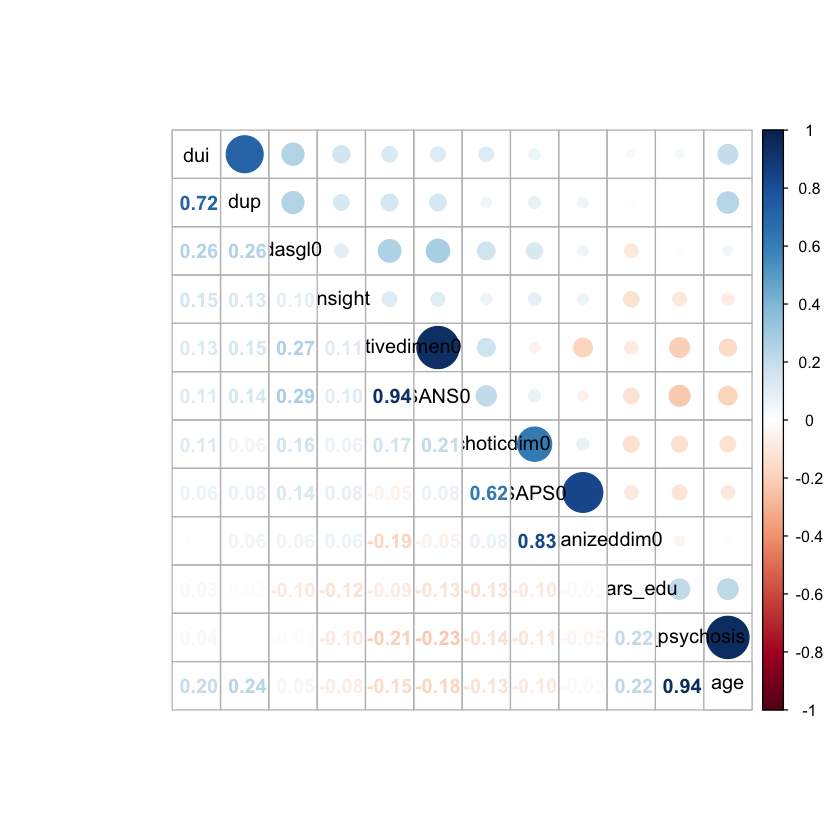

In [333]:
library(corrplot)
full_data %>%
    select(-cds0) %>%
    select(where(is.numeric)) %>%
    # fill in all missing values with the mean
    mutate(across(where(is.numeric), ~ ifelse(is.na(.x), mean(.x, na.rm = TRUE), .x))) %>%
    # normalize all numeric variables
    mutate(across(where(is.numeric), ~ (.x - min(.x)) / (max(.x) - min(.x)))) %>%
    cor() %>%
    corrplot.mixed(order = 'AOE', upper = 'circle', tl.col = 'black')

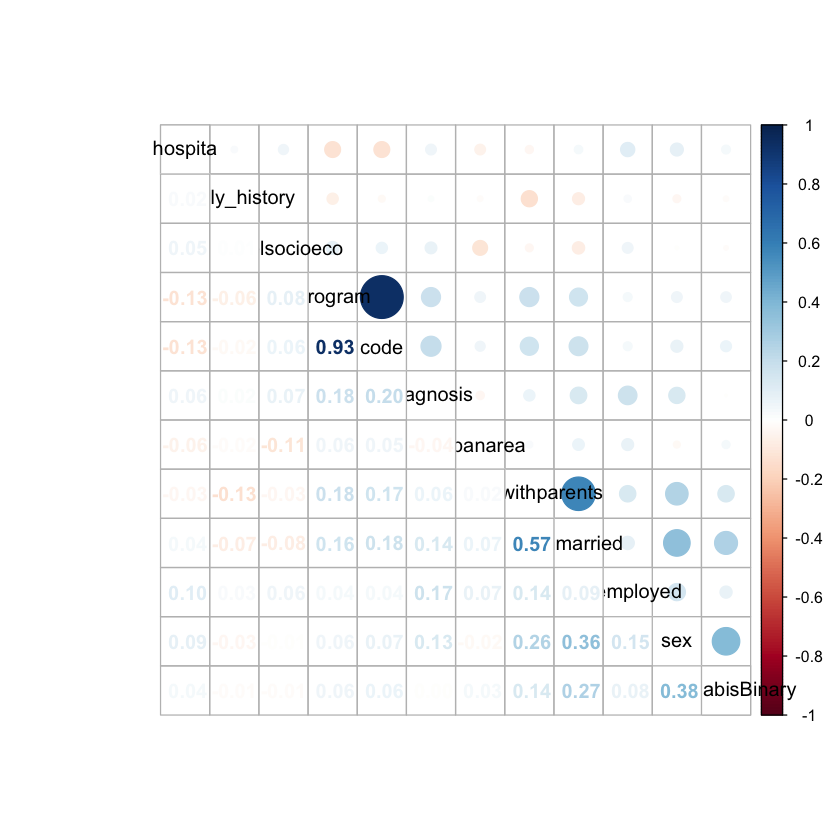

In [335]:
full_data %>%
    select(-cds0) %>%
    select(where(is.factor)) %>%
    drop_na() %>%
    mutate(across(where(is.factor), ~ as.numeric(.x))) %>%
    # normalize all numeric variables
    mutate(across(where(is.numeric), ~ (.x - min(.x)) / (max(.x) - min(.x)))) %>%
    cor() %>%
    corrplot.mixed(order = 'AOE', upper = 'circle', tl.col = 'black')

In [336]:
full_data <- full_data %>%
    select(-SANS0, -age) %>%
    mutate(across(where(is.numeric), ~ ifelse(is.na(.x), mean(.x, na.rm = TRUE), .x)))

In [337]:
full_data %>% summary()

      code     Program sex     age_psychosis   family_history hospita   
 1      :  1   1:174   0:311   Min.   :14.81   1   :127       1   :379  
 2      :  1   2: 20   1:238   1st Qu.:21.65   2   :420       2   :169  
 3      :  1   3:203           Median :26.92   NA's:  2       NA's:  1  
 4      :  1   4:152           Mean   :28.92                            
 5      :  1                   3rd Qu.:34.25                            
 6      :  1                   Max.   :59.80                            
 (Other):543                                                            
      dui              dup         levelsocioeco urbanarea  livingwithparents
 Min.   :  0.10   Min.   :  0.06   1   :282      1   :386   1   :273         
 1st Qu.:  2.00   1st Qu.:  1.00   2   :249      2   :154   2   :270         
 Median : 10.00   Median :  3.00   NA's: 18      NA's:  9   NA's:  6         
 Mean   : 21.88   Mean   : 12.51                                             
 3rd Qu.: 24.00   3rd Qu.:

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


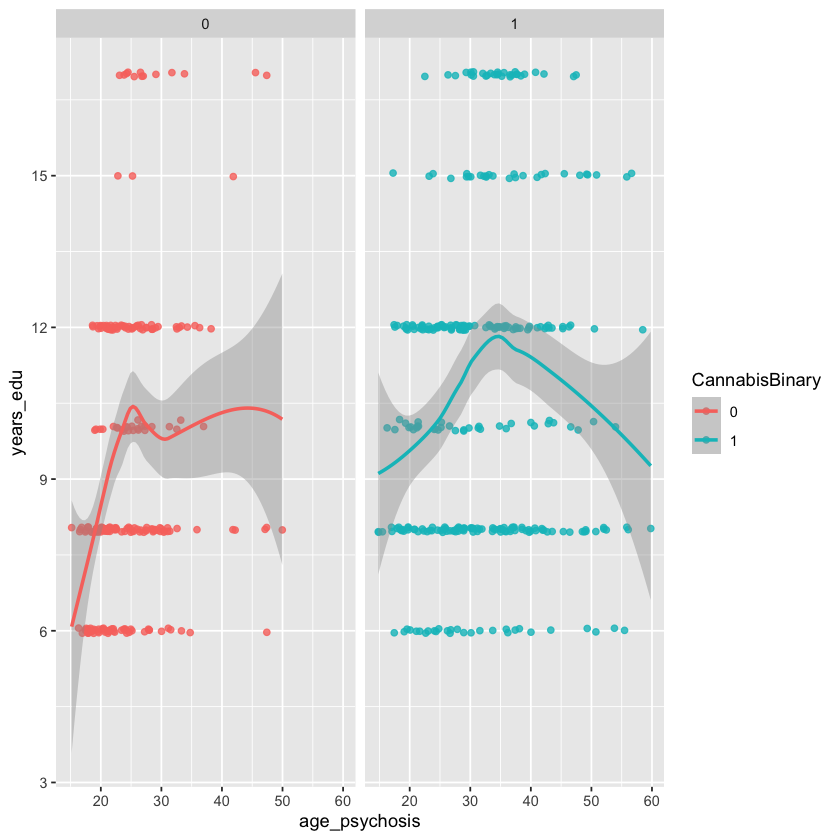

In [338]:
full_data %>%
    ggplot(aes(x = age_psychosis, y = years_edu, color = CannabisBinary)) +
    geom_jitter(alpha = 0.8) +
    facet_wrap(~CannabisBinary) +
    geom_smooth()

In [339]:
full_data %>%names()

[1] "code"              "Program"           "sex"              
 [4] "age_psychosis"     "family_history"    "hospita"          
 [7] "dui"               "dup"               "levelsocioeco"    
[10] "urbanarea"         "livingwithparents" "unmarried"        
[13] "unemployed"        "years_edu"         "CannabisBinary"   
[16] "SAPS0"             "Psychoticdim0"     "Disorganizeddim0" 
[19] "Negativedimen0"    "dasgl0"            "diagnosis"        
[22] "insight"           "cds0"

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


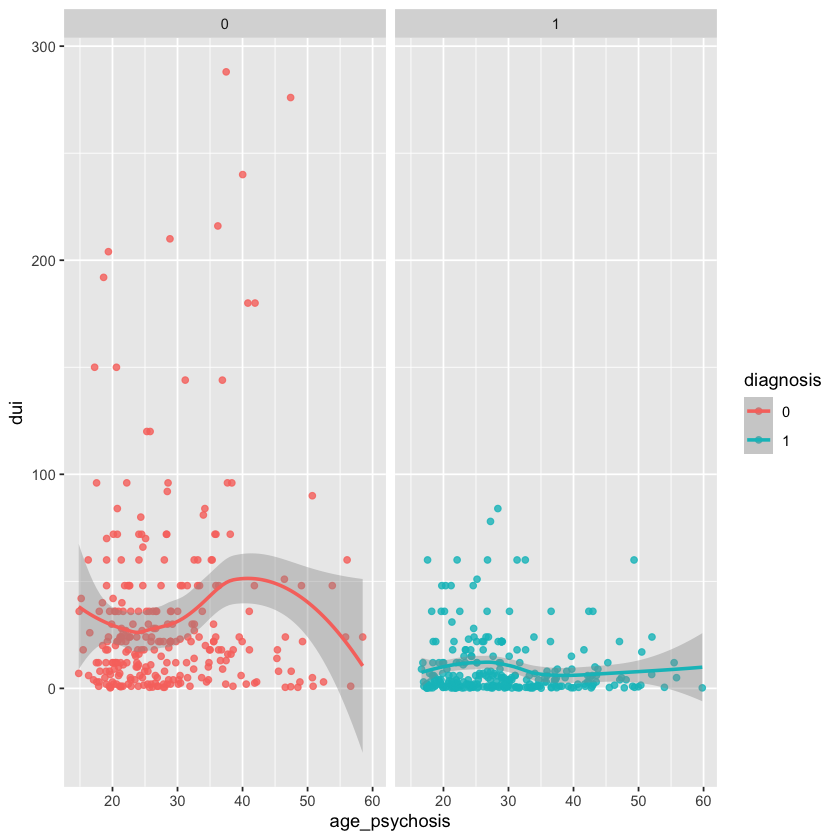

In [340]:
full_data %>%
    ggplot(aes(x = age_psychosis, y = dui, color = diagnosis)) +
    geom_jitter(alpha = 0.8) +
    facet_wrap(~diagnosis) +
    geom_smooth()

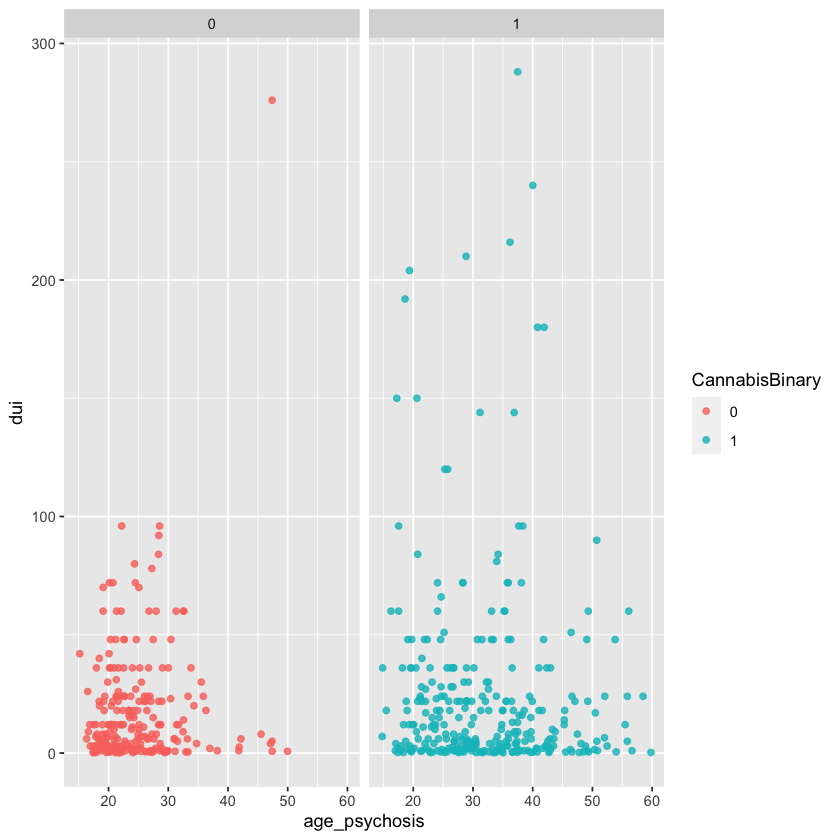

In [344]:
full_data %>%
    ggplot(aes(x = age_psychosis, y = dui, color = CannabisBinary)) +
    geom_jitter(alpha = 0.8) +
    facet_wrap(~CannabisBinary)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


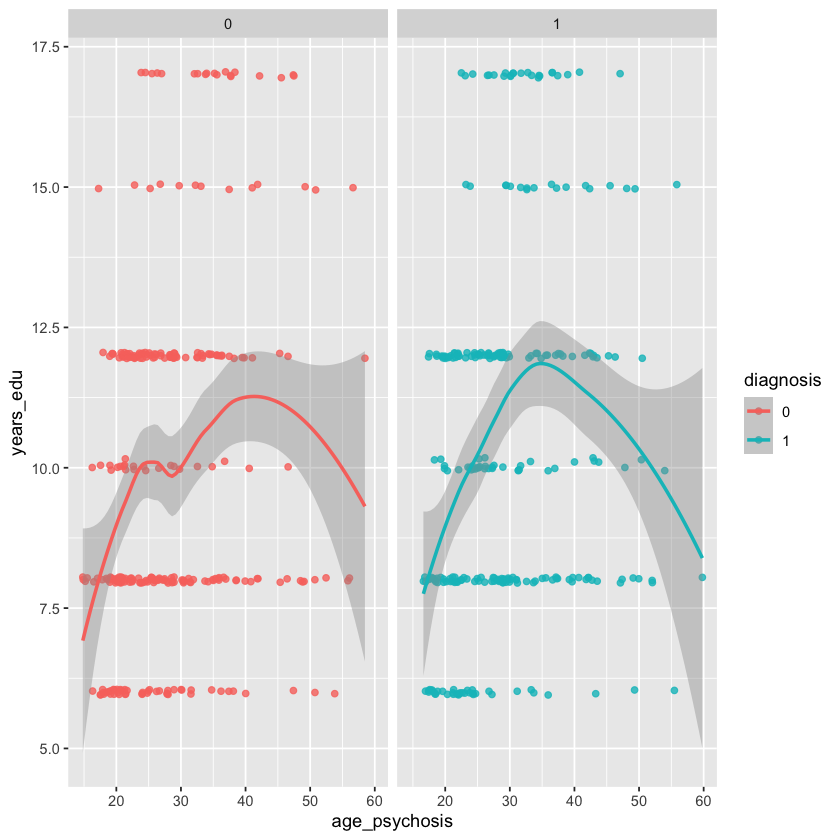

In [324]:
full_data %>%
    ggplot(aes(x = age_psychosis, y = years_edu, color = diagnosis)) +
    geom_jitter(alpha = 0.8) +
    facet_wrap(~diagnosis)

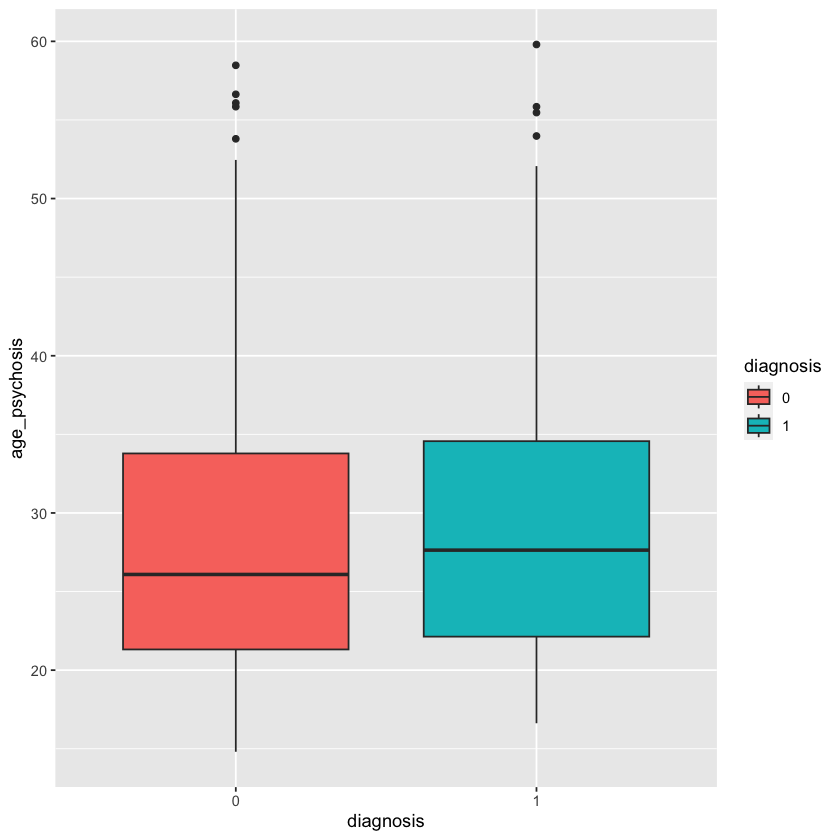

In [314]:
full_data %>%
    ggplot() +
    geom_boxplot(aes(x = diagnosis, y = age_psychosis, fill = diagnosis))

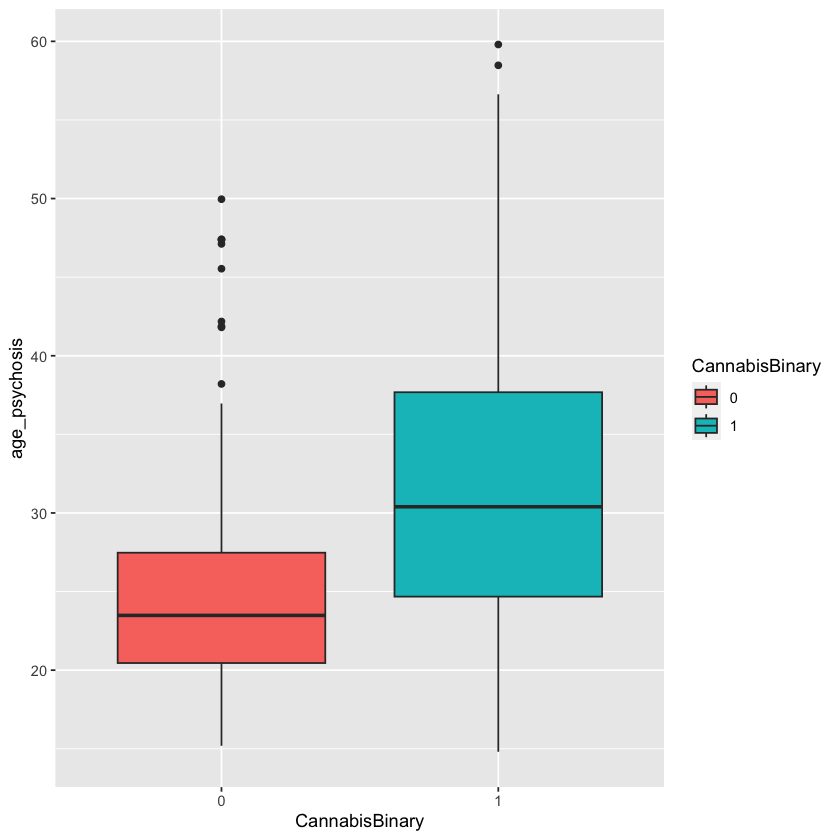

In [307]:
full_data %>%
    ggplot() +
    geom_boxplot(aes(x = CannabisBinary, y = age_psychosis, fill = CannabisBinary))

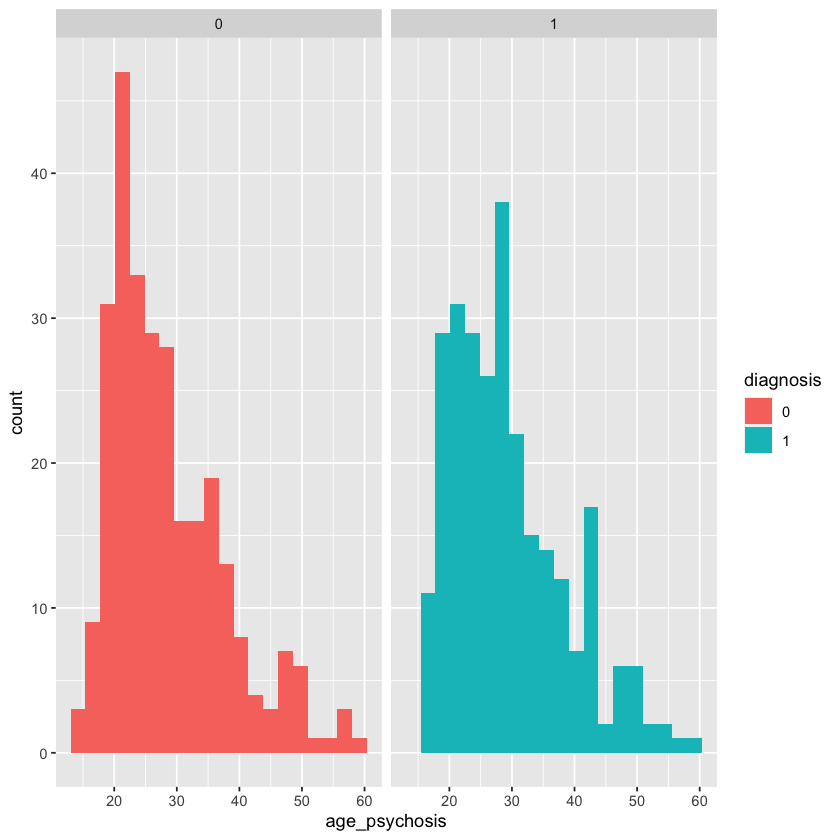

In [354]:
full_data %>%
    ggplot() +
    geom_histogram(aes(x = age_psychosis, fill = diagnosis), bins = 20) +
    facet_wrap(~diagnosis)

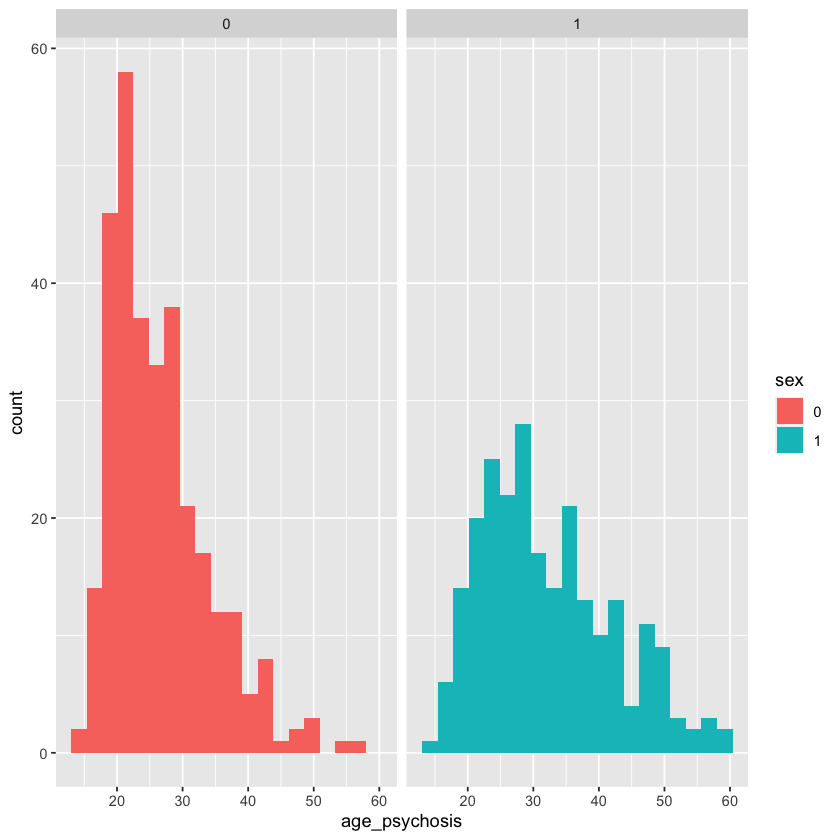

In [353]:
full_data %>%
    ggplot() +
    geom_histogram(aes(x = age_psychosis, fill = sex), bins = 20) +
    facet_wrap(~sex)

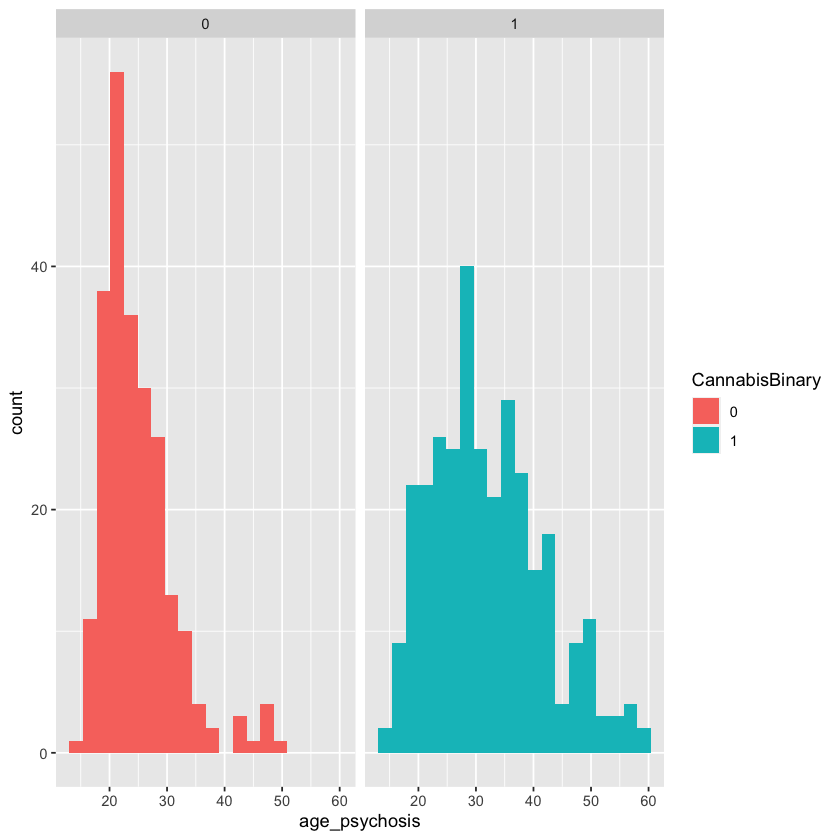

In [351]:
full_data %>%
    ggplot() +
    geom_histogram(aes(x = age_psychosis, fill = CannabisBinary), bins = 20) +
    facet_wrap(~CannabisBinary)

In [348]:
full_data %>% names()

[1] "code"              "Program"           "sex"              
 [4] "age_psychosis"     "family_history"    "hospita"          
 [7] "dui"               "dup"               "levelsocioeco"    
[10] "urbanarea"         "livingwithparents" "unmarried"        
[13] "unemployed"        "years_edu"         "CannabisBinary"   
[16] "SAPS0"             "Psychoticdim0"     "Disorganizeddim0" 
[19] "Negativedimen0"    "dasgl0"            "diagnosis"        
[22] "insight"           "cds0"

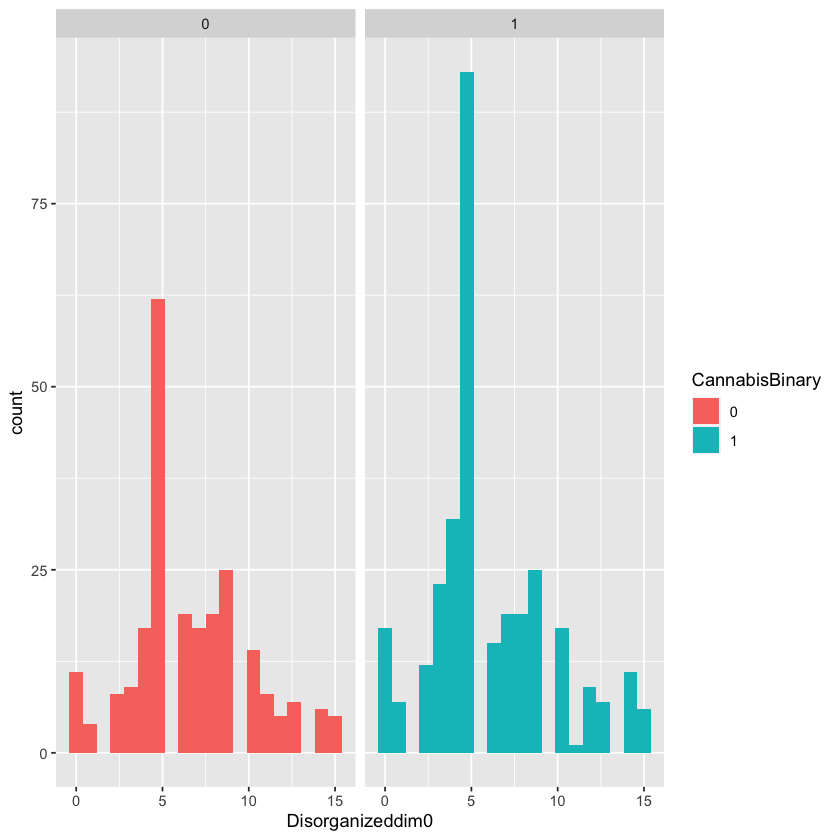

In [350]:
full_data %>%
    ggplot() +
    geom_histogram(aes(x = Disorganizeddim0, fill = CannabisBinary), bins = 20) +
    facet_wrap(~CannabisBinary)

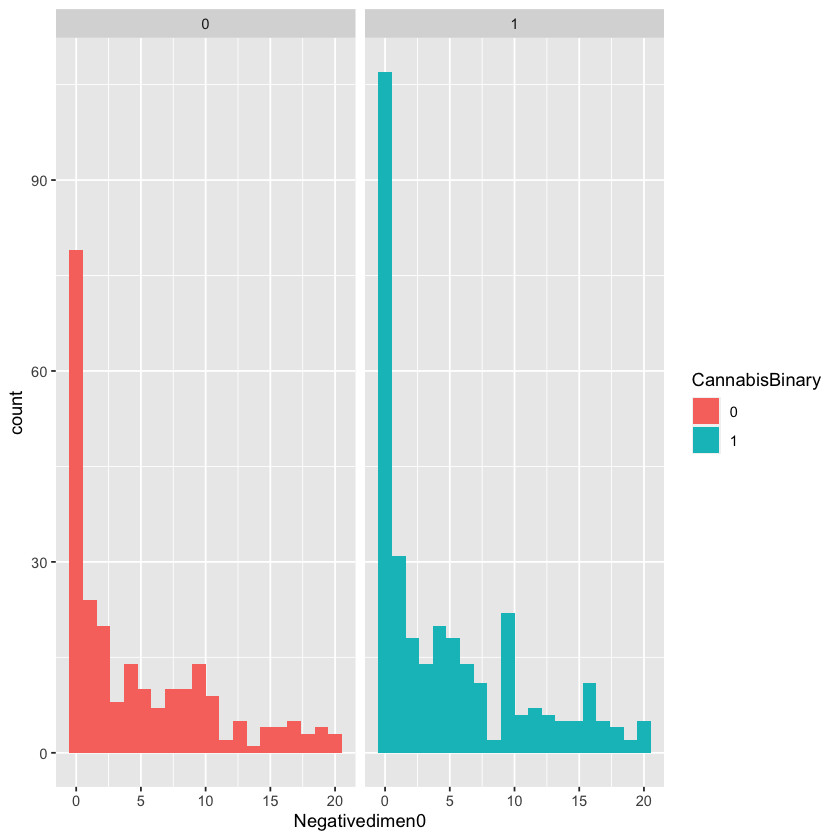

In [360]:
full_data %>%
    ggplot() +
    geom_histogram(aes(x = Negativedimen0, fill = CannabisBinary), bins = 20) +
    facet_wrap(~CannabisBinary)

Warning message in geom_bar(aes(x = levelsocioeco, fill = CannabisBinary), bins = 20):
"Ignoring unknown parameters: `bins`"


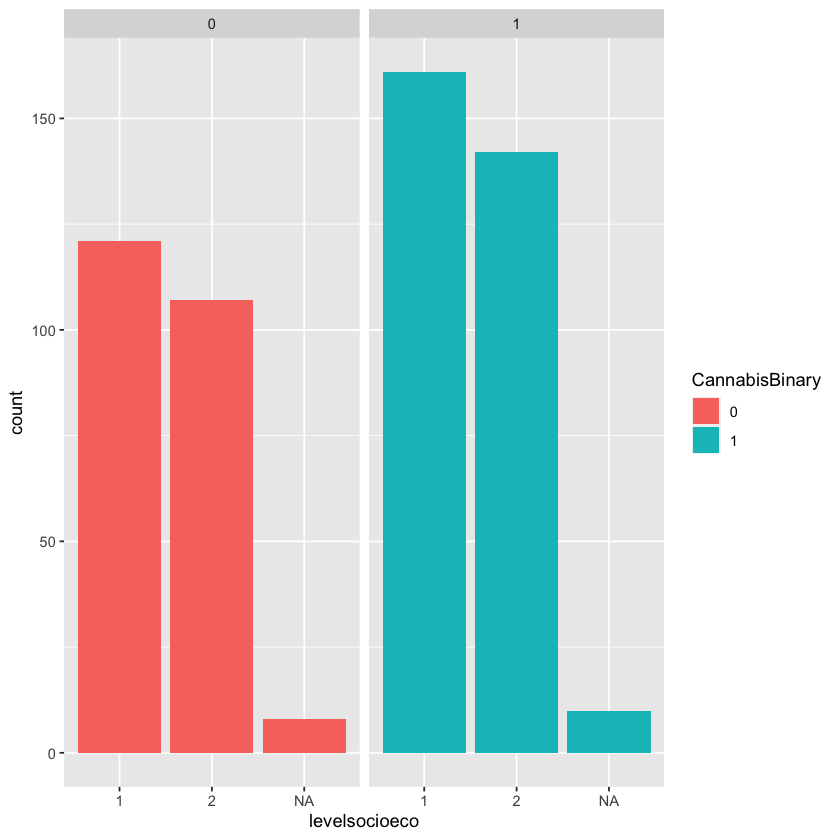

In [363]:
full_data %>%
    ggplot() +
    geom_bar(aes(x = levelsocioeco, fill = CannabisBinary), bins = 20) +
    facet_wrap(~CannabisBinary)

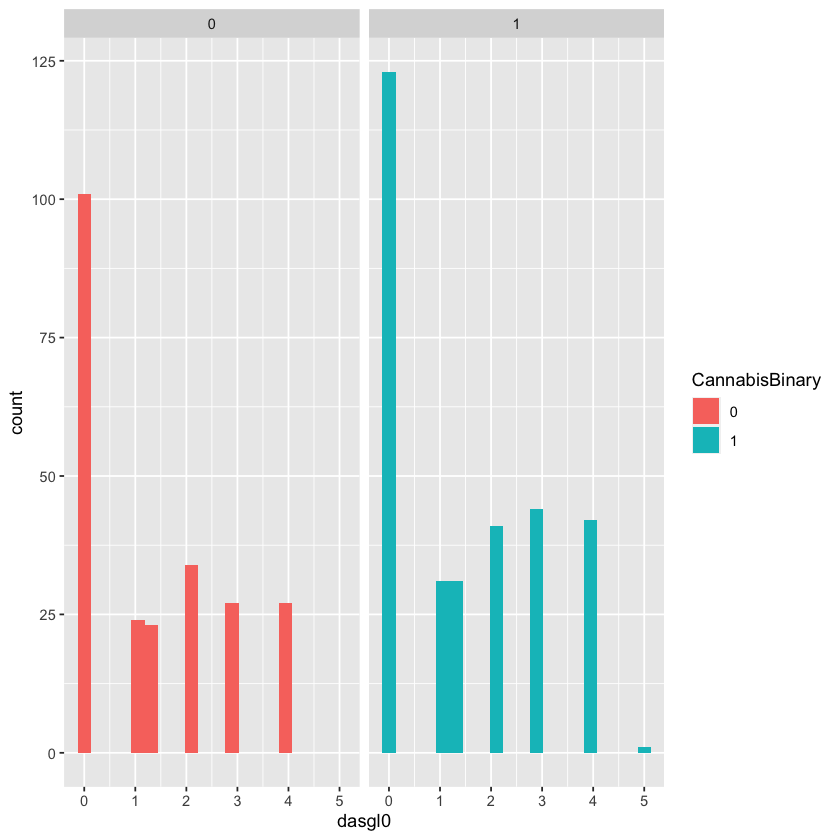

In [369]:
full_data %>%
    ggplot() +
    geom_histogram(aes(x = dasgl0, fill = CannabisBinary), bins = 20) +
    facet_wrap(~CannabisBinary)

In [377]:
full_data %>%
    group_by(CannabisBinary, diagnosis) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(CannabisBinary) %>%
    mutate(diagnosis_gvn_cannabis = n / sum(n)) %>%
    ungroup() %>%
    group_by(diagnosis) %>%
    mutate(cannabis_gvn_diagnosis = n / sum(n)) %>%
    ungroup()

`summarise()` has grouped output by 'CannabisBinary'. You can override using
the `.groups` argument.


CannabisBinary,diagnosis,n,diagnosis_gvn_cannabis,cannabis_gvn_diagnosis
<fct>,<fct>,<int>,<dbl>,<dbl>
0,0,119,0.5042373,0.4280576
0,1,117,0.4957627,0.4317343
1,0,159,0.5079872,0.5719424
1,1,154,0.4920128,0.5682657


In [378]:
full_data %>% write_csv("../data/clean_data/full_data.csv")